# Classic CV

## Packages

In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi
from sklearn.metrics import confusion_matrix

## Import data

In [2]:
path = '../data/HRF/'
files = sorted(os.listdir(path))
data = {
    'original': [],
    'labeled': [],
    'mask': []
}
for file in files:
    if file.endswith('h.jpg'):
        data['original'].append(cv2.imread(f'{path}{file}'))
    elif file.endswith('h.tif'):
        data['labeled'].append(cv2.imread(f'{path}{file}',0))
    elif file.endswith('h_mask.tif'):
        data['mask'].append(cv2.imread(f'{path}{file}',0))

In [3]:
for type_ in data:
    print(len(data[type_]))
    print(data[type_][0].shape, data[type_][0].max(), data[type_][0].min())

15
(2336, 3504, 3) 255 0
15
(2336, 3504) 255 0
15
(2336, 3504) 255 0


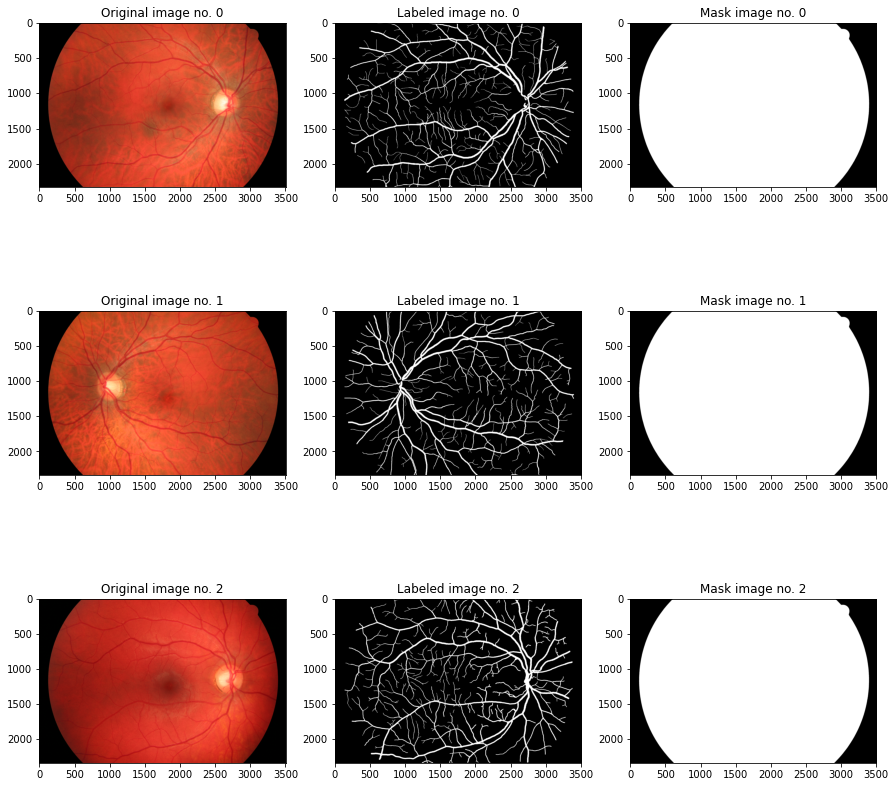

In [4]:
columns, rows = 3, 3
plt.figure(figsize=(5*columns, 5*rows))

for i in range(0, columns*rows):
    plt.subplot(rows, columns, i+1)
    number = int(i/3)
    if i%3 == 0:
        img = data['original'][number]
        plt.title(f'Original image no. {number}')
        plt.imshow(img[:,:,::-1])
    elif i%3 == 1:
        img = data['labeled'][number]
        plt.title(f'Labeled image no. {number}')
        plt.imshow(img, cmap='gray')
    elif i%3 == 2:
        img = data['mask'][number]
        plt.title(f'Mask image no. {number}')
        plt.imshow(img, cmap='gray')
plt.show()

## Analysis

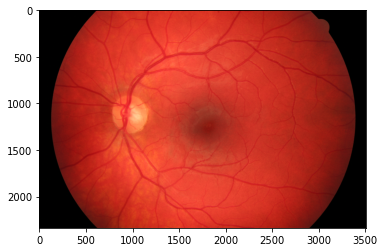

In [5]:
testing_subject, testing_subject_labeled, testing_subject_mask = data['original'][3], data['labeled'][3], data['mask'][3]
plt.imshow(testing_subject[:,:,::-1])

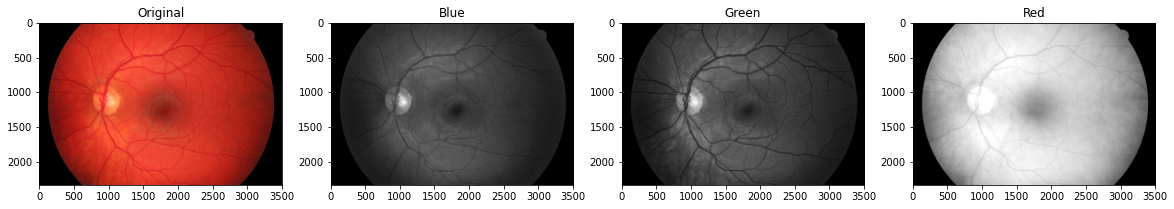

In [6]:
testing_subject_color = {'b': testing_subject[:,:,0], 'g': testing_subject[:,:,1], 'r': testing_subject[:,:,2]}

plt.figure(figsize=(20,12))
subplots = [1, 2, 3, 4]
titles = ['Original', 'Blue', 'Green', 'Red']
channels = ['all', 'b', 'g', 'r']

for subplot, title, channel in zip(subplots, titles, channels):
    plt.subplot(1, 4, subplot)
    if channel == 'all':
        plt.imshow(testing_subject[:,:,::-1])
    else:
        plt.imshow(testing_subject_color[channel], cmap='gray')
    plt.title(title)

## Functions

[0. 0. 0. ... 0. 0. 0.] 0.0 255.0


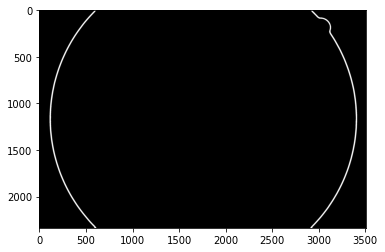

In [7]:
def normalize(image):
    filtered_min, filtered_max = image.min(), image.max()
    return ((image-filtered_min)/(filtered_max-filtered_min))*255

# plt.imshow(cv2.threshold(difference_of_gaussians(frangi(testing_subject_mask), 8), 230, 255, cv2.THRESH_BINARY), cmap='gray')
# picture = normalize(difference_of_gaussians(frangi(testing_subject_mask), 8))
picture = (frangi(testing_subject_mask))
picture = cv2.blur(picture, (30, 30))
picture = normalize(picture)
_, picture = cv2.threshold(picture, 190, 255, cv2.THRESH_BINARY)
print(picture[0], picture.min(), picture.max())
plt.imshow(picture, cmap='gray')

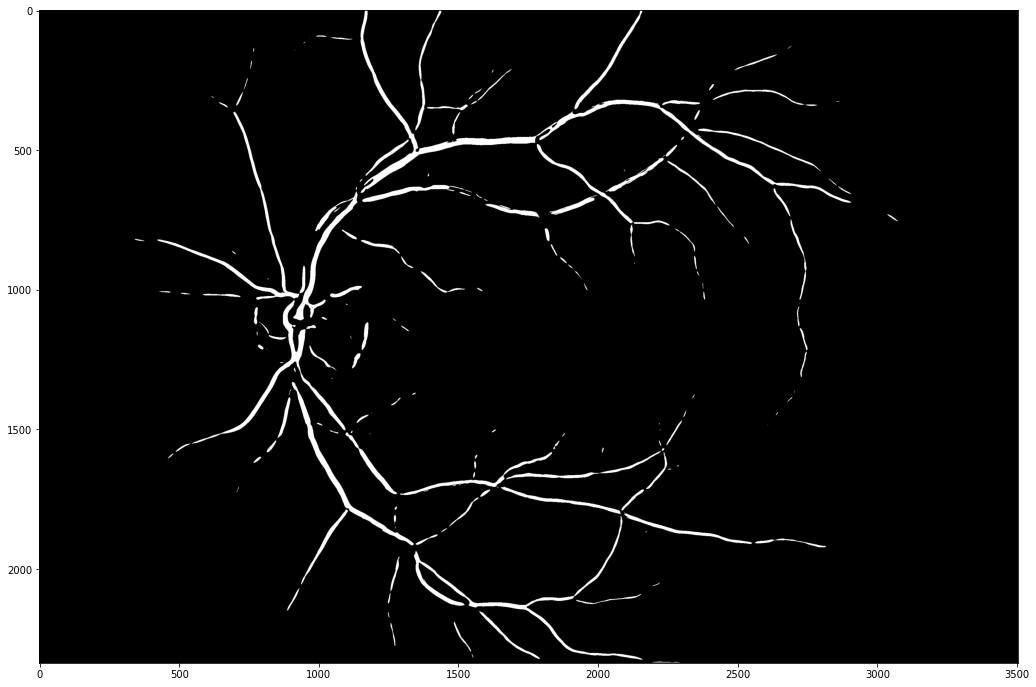

In [13]:
plt.figure(figsize=(20,12))

def normalize(image):
    filtered_min, filtered_max = image.min(), image.max()
    return (1-(image-filtered_min)/(filtered_max-filtered_min))*255

def create_result(image, mask, threshold):
    filtered = frangi(image)
    mask = (frangi(mask))
    mask = cv2.blur(mask, (30, 30))
    mask = normalize(mask)
    _, mask = cv2.threshold(mask, 190, 255, cv2.THRESH_BINARY)
    image = normalize(filtered)
    _, image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY_INV)
    image, mask = image.astype(np.uint8), mask.astype(np.uint8)
    image = cv2.bitwise_and(image, image, mask=mask)
    return image
test_image = create_result(testing_subject_color['g'], testing_subject_mask, 230)
plt.imshow(test_image, cmap='gray')

## Metrics

In [9]:
def get_metrics(result, real):
    conf = confusion_matrix(result.flatten(), real.flatten())
    TN, FP, FN, TP = conf.ravel()

    accuracy = 1.0 * (TP + TN) / (TP + TN + FP + FN)
    sensitivity = 1.0 * TP / (TP + FN)
    specificity = 1.0 * TN / (TN + FP)

    return accuracy, sensitivity, specificity

In [10]:
get_metrics(test_image, testing_subject_labeled)

(0.9308565406658535, 0.9792666896622447, 0.9295535836383002)

In [ ]:
accuracy_list = []
sensitivity_list = []
specificity_list = []
thresholds = list(range(100, 201, 5))
for threshold in thresholds:
    accuracy = []
    sensitivity = []
    specificity = []
    for i in range(10):
        test_image = create_result(data['original'][i][:,:,1], data['mask'][i], threshold)
        metrics = get_metrics(test_image, data['labeled'][i])
        accuracy.append(metrics[0])
        sensitivity.append(metrics[1])
        specificity.append(metrics[2])
    accuracy_list.append(np.mean(accuracy))
    sensitivity_list.append(np.mean(sensitivity))
    specificity_list.append(np.mean(specificity))


In [ ]:
import matplotlib.pyplot as plt

plt.plot(thresholds, accuracy_list, label = 'accuracy')
plt.plot(thresholds, sensitivity_list, label = 'sensitivity')
plt.plot(thresholds, specificity_list, label = 'specificity')
plt.legend()
plt.show()